In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook as tq

In [2]:
DATA_DIR = "../game_num_data/"

In [3]:
def make_df():
    columns = ["状況", "回"]
    event_list = []
    for file in tq(os.listdir(DATA_DIR)[1:]):
        curr_event_list = pd.read_csv(DATA_DIR+file, encoding="cp932", index_col=0, dtype="object")[columns].values.tolist()
        new_event_list = []
        for i in range(len(curr_event_list)):
            new_event_list.append(curr_event_list[i])
            if i < len(curr_event_list)-1 and curr_event_list[i][0] == "2" and curr_event_list[i+1][0] == "1":
                new_event_list.append(["3000", curr_event_list[i][1]])
                new_event_list.append(["0000", curr_event_list[i+1][1]])
        event_list.extend(new_event_list+[["GAMESET", np.nan]])
    for i in range(len(event_list)):
        if event_list[i][1] is np.nan:
            if event_list[i][0] != "GAMESET":
                event_list[i][1] = event_list[i-1][1]
    return pd.DataFrame(event_list, columns=columns)

In [4]:
event_df = make_df()

In [5]:
event_df.head()

,状況,回
0,0000,1回表
1,1000,1回表
2,2000,1回表
3,3000,1回表
4,0000,1回裏


In [6]:
inning_list = []
for inning in range(10):
    curr_inning_list = []
    for i in range(len(event_df)):
        if event_df.iloc[i, 0] == "GAMESET":
            continue
        if int(event_df.iloc[i, 1].split("回")[0]) == inning + 1:
            curr_inning_list.append(event_df.iloc[i, 0])
    inning_list.append(curr_inning_list)

In [7]:
inning_triple_list = []
for inning in range(len(inning_list)):
    curr_triple = []
    for i in range(2, len(inning_list[inning])):
        before, curr, after = inning_list[inning][i-2], inning_list[inning][i-1], inning_list[inning][i]
        if "GAMESET" in [before, curr, after]:
            continue
        if before == "3000" or curr == "3000":
            continue
        curr_triple.append((before, curr, after))
    inning_triple_list.append(curr_triple)

In [8]:
len(inning_triple_list)

10

In [9]:
all_triple_list = []
for triple_list in inning_triple_list:
    all_triple_list += triple_list
all_triple_set = set(all_triple_list)

In [10]:
# 状況とインデックスの対応dict
case_dict = dict()
for i, triple in enumerate(all_triple_set):
    case_dict[triple] = i

In [11]:
def to_index(lst):
    return [case_dict[elem] for elem in lst]

In [12]:
inning_triple_index_list = []
for lst in inning_triple_list:
    inning_triple_index_list.append(to_index(lst))

In [13]:
# KS検定の結果
df = pd.DataFrame(index=[_ for _ in range(1, 11)], columns=[_ for _ in range(1, 11)]).astype(float)
for i in range(10):
    for j in range(10):
        df.iloc[i, j] = stats.ks_2samp(inning_triple_index_list[i], inning_triple_index_list[j]).statistic

In [14]:
stats.ks_2samp(inning_triple_index_list[0], inning_triple_index_list[1])

Ks_2sampResult(statistic=0.032630399494347317, pvalue=0.0061792980321932166)

In [15]:
df

,1,2,3,4,5,6,7,8,9,10
1,0.000000,0.032630,0.029722,0.029014,0.026053,0.014149,0.016377,0.019920,0.033378,0.070059
2,0.032630,0.000000,0.026419,0.019523,0.020903,0.032051,0.019938,0.038915,0.034583,0.066921
3,0.029722,0.026419,0.000000,0.012784,0.008928,0.020382,0.024731,0.018456,0.010793,0.045560
4,0.029014,0.019523,0.012784,0.000000,0.007155,0.018490,0.023662,0.025104,0.020768,0.053745
5,0.026053,0.020903,0.008928,0.007155,0.000000,0.015570,0.020382,0.021060,0.016935,0.049861
6,0.014149,0.032051,0.020382,0.018490,0.015570,0.000000,0.016598,0.015540,0.022320,0.061026
7,0.016377,0.019938,0.024731,0.023662,0.020382,0.016598,0.000000,0.023092,0.028958,0.066216
8,0.019920,0.038915,0.018456,0.025104,0.021060,0.015540,0.023092,0.000000,0.014580,0.055155
9,0.033378,0.034583,0.010793,0.020768,0.016935,0.022320,0.028958,0.014580,0.000000,0.042926
10,0.070059,0.066921,0.045560,0.053745,0.049861,0.061026,0.066216,0.055155,0.042926,0.000000


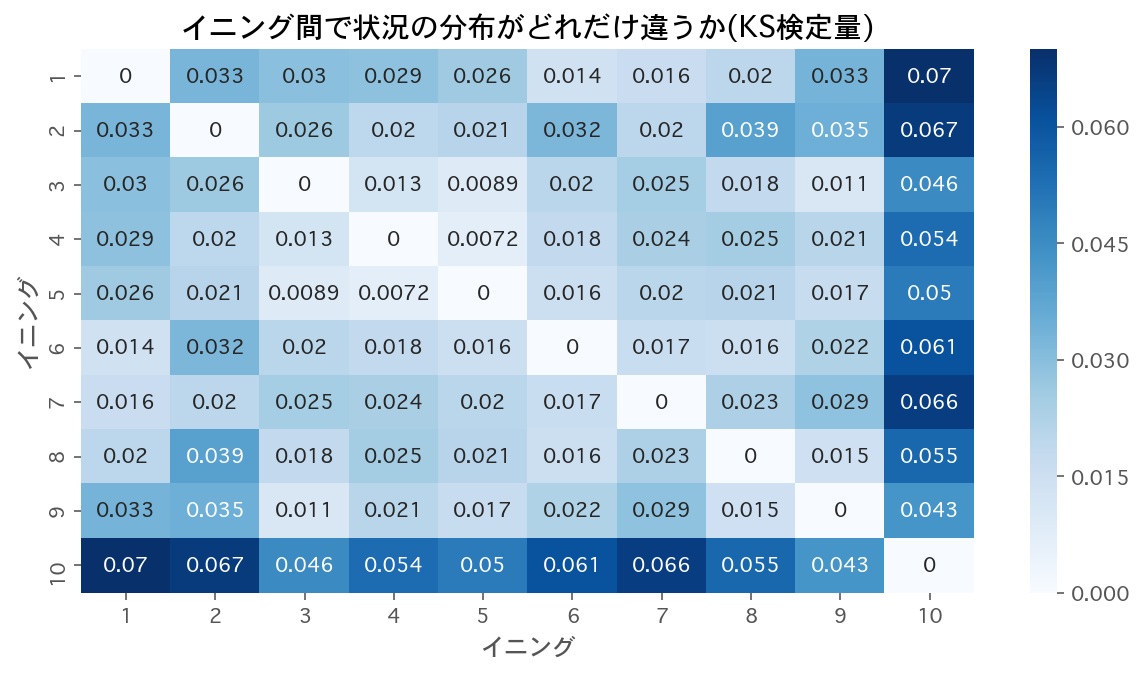

In [16]:
plt.figure(figsize=(10, 5))
sns.heatmap(df, cmap="Blues", annot=True)
plt.xlabel("イニング")
plt.ylabel("イニング")
plt.title("イニング間で状況の分布がどれだけ違うか(KS検定量)")

# 1回の分布は他と明らかに異なる